In [63]:
import logging
logging.disable(logging.INFO)
import pandas as pd
import pandas as pd
import numpy as np
import pathlib
from sklearn.metrics.pairwise import cosine_similarity, nan_euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import matplotlib;
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

In [64]:
%matplotlib inline
encoded_dict = {1: "POSITIVE ", 0: "UNCERTAIN ", -1:"NEGATIVE ", np.NaN: 'unmentioned'}
plt.style.use('default')

def show_image(idx):
    image_path = os.path.join('../data/raw/',raw_df.loc[idx]["Path"])
    im = Image.open(image_path)
    return im

def show_image_and_feats(idx):
    plt.figure(figsize = (20,10))
    plt.imshow(show_image(idx), cmap = 'bone')
    display(pd.DataFrame(raw_df.loc[idx].drop('Path')).T.replace(to_replace = encoded_dict))
    plt.show()

def show_image_and_complement(idx,complementary_feat):
    row = raw_df.loc[idx]
    idx_complement = (raw_df[raw_df[complementary_feat] == 0-row[complementary_feat]] == row).sum(axis=1).idxmax()
    
    # features as series
    feats_original = raw_df.loc[idx].drop('Path')
    feats_complement = raw_df.loc[idx_complement].drop('Path')
    comparison_table = pd.concat((feats_original,feats_complement), axis = 1).T
    
    
    # images
    img_A = show_image(idx)
    img_B = show_image(idx_complement)
    
    # plot
    fig, ax = plt.subplots(1,2,figsize=(30,15))
    ax[0].imshow(img_A,cmap = 'bone');
    ax[0].set_title(str(encoded_dict[row[complementary_feat]]) + str(complementary_feat) + ' ' + 'Pt ID: ' +  str(idx)+'\n')
    
    ax[1].imshow(img_B,cmap = 'bone')
    ax[1].set_title(str(encoded_dict[0-row[complementary_feat]]) + str(complementary_feat) + ' ' + 'Pt ID: ' +  str(idx_complement) +'\n')
    
    return comparison_table.replace(to_replace = encoded_dict)


raw_df_path = '../data/processed/ProcessChexpertDfToParquet/part.0.parquet'
normalized_df_path = '../data/processed/NormalizeDF/part.0.parquet'

raw_df = pd.read_parquet(raw_df_path)
normalized_df = pd.read_parquet(normalized_df_path)

In [78]:
special_1_idx = 78414

Sex  Age Frontal/Lateral AP/PA   No Finding  \
78414  Female   40         Frontal    AP  unmentioned   

      Enlarged Cardiomediastinum Cardiomegaly Lung Opacity  Lung Lesion  \
78414                unmentioned  unmentioned    POSITIVE   unmentioned   

             Edema Consolidation  Pneumonia  Atelectasis Pneumothorax  \
78414  unmentioned   unmentioned  POSITIVE   unmentioned    POSITIVE    

      Pleural Effusion Pleural Other     Fracture Support Devices  
78414      unmentioned   unmentioned  unmentioned     unmentioned

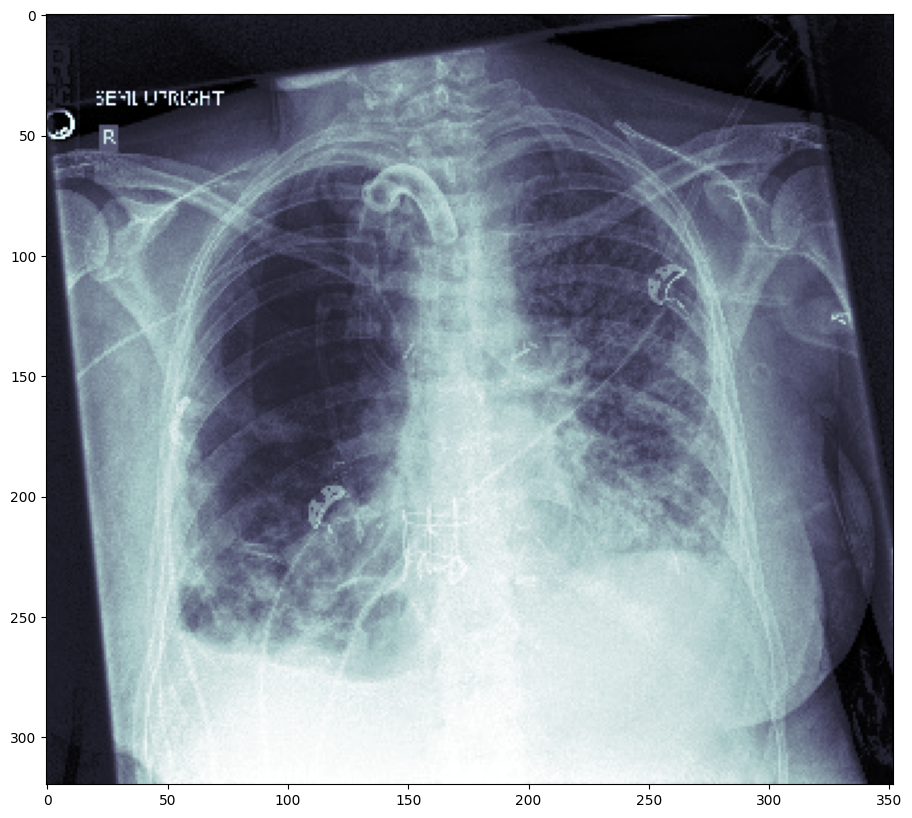

In [84]:
show_image_and_feats(special_1_idx)

We have our raw data here

![raw](https://stanfordmlgroup.github.io/competitions/chexpert/img/figure2.png)

Sex  Age Frontal/Lateral AP/PA   No Finding  \
78414  Female   40         Frontal    AP  unmentioned   
29247  Female   40         Frontal    AP  unmentioned   

      Enlarged Cardiomediastinum Cardiomegaly Lung Opacity  Lung Lesion  \
78414                unmentioned  unmentioned    POSITIVE   unmentioned   
29247                unmentioned  unmentioned    POSITIVE   unmentioned   

             Edema Consolidation  Pneumonia  Atelectasis Pneumothorax  \
78414  unmentioned   unmentioned  POSITIVE   unmentioned    POSITIVE    
29247  unmentioned   unmentioned  NEGATIVE     NEGATIVE     POSITIVE    

      Pleural Effusion Pleural Other     Fracture Support Devices  
78414      unmentioned   unmentioned  unmentioned     unmentioned  
29247        POSITIVE    unmentioned  unmentioned     unmentioned

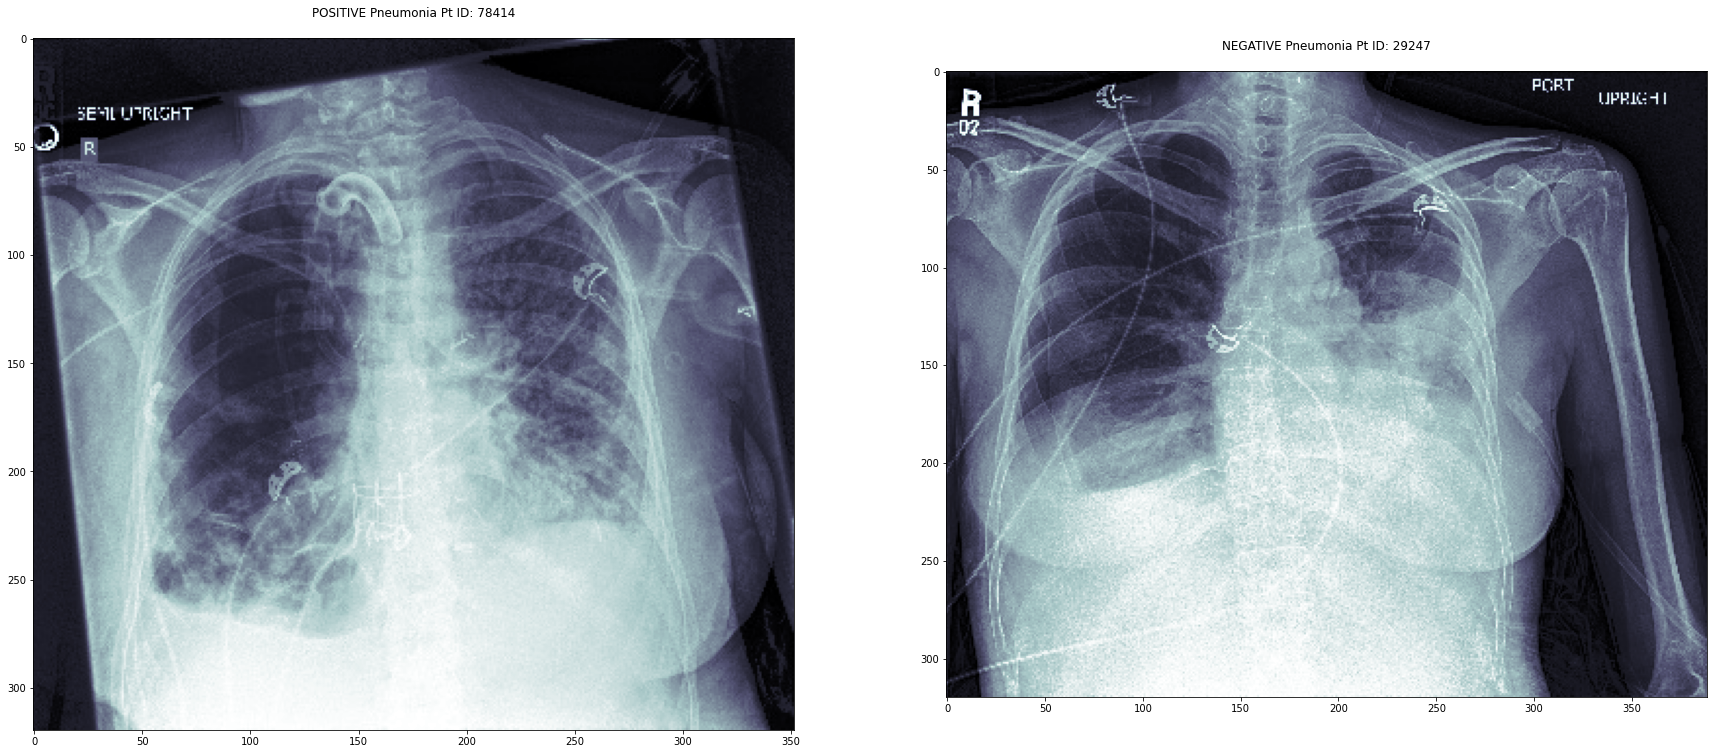

In [11]:
comparison_table = show_image_and_complement(special_1_idx,'Pneumonia')
comparison_table

Sex  Age Frontal/Lateral AP/PA   No Finding  \
78414  Female   40         Frontal    AP  unmentioned   
43170  Female   78         Frontal    AP  unmentioned   

      Enlarged Cardiomediastinum Cardiomegaly Lung Opacity  Lung Lesion  \
78414                unmentioned  unmentioned    POSITIVE   unmentioned   
43170                  POSITIVE     POSITIVE     POSITIVE   unmentioned   

             Edema Consolidation  Pneumonia  Atelectasis Pneumothorax  \
78414  unmentioned   unmentioned  POSITIVE   unmentioned    POSITIVE    
43170    NEGATIVE    unmentioned  POSITIVE   unmentioned    NEGATIVE    

      Pleural Effusion Pleural Other     Fracture Support Devices  
78414      unmentioned   unmentioned  unmentioned     unmentioned  
43170        POSITIVE    unmentioned  unmentioned     unmentioned

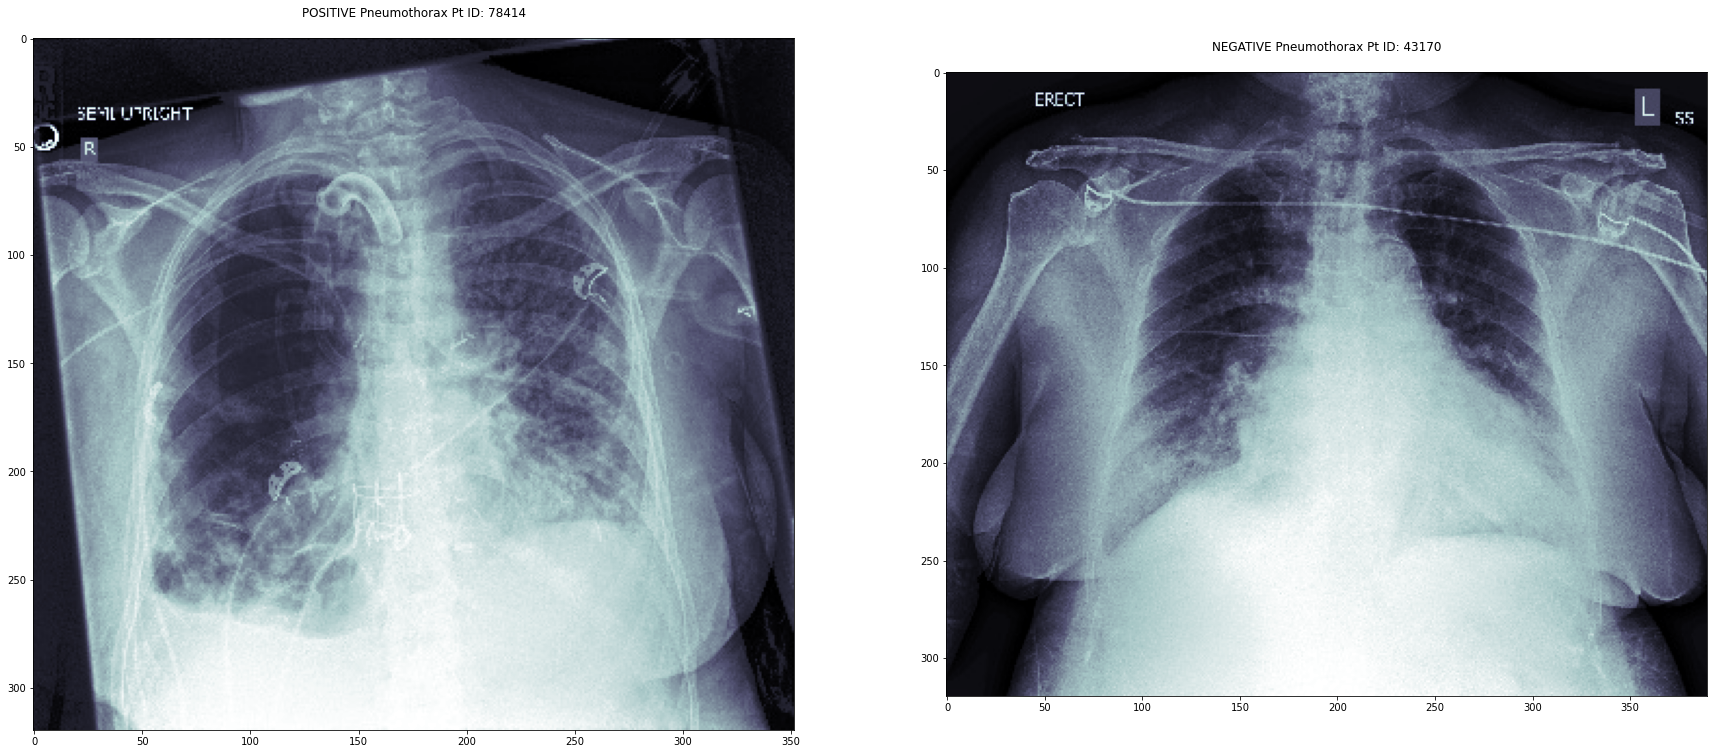

In [12]:
comparison_table = show_image_and_complement(special_1_idx,'Pneumothorax')
comparison_table

<AxesSubplot:>

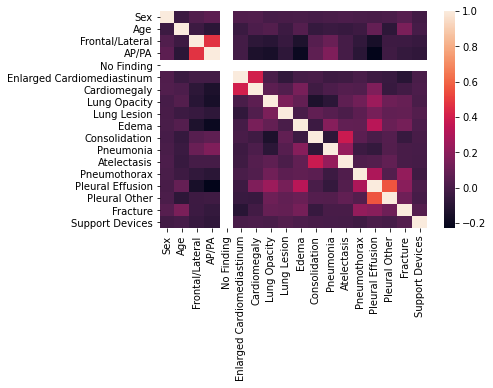

In [13]:
sns.heatmap(normalized_df.corr())

In [14]:
sample_df = normalized_df.replace([np.inf, -np.inf], np.nan).fillna(-1)

In [15]:
from sklearn.decomposition import PCA
X = PCA(n_components=2).fit_transform(sample_df)

c = MinMaxScaler().fit_transform((sample_df==True).sum(axis=1).values.reshape(-1,1))

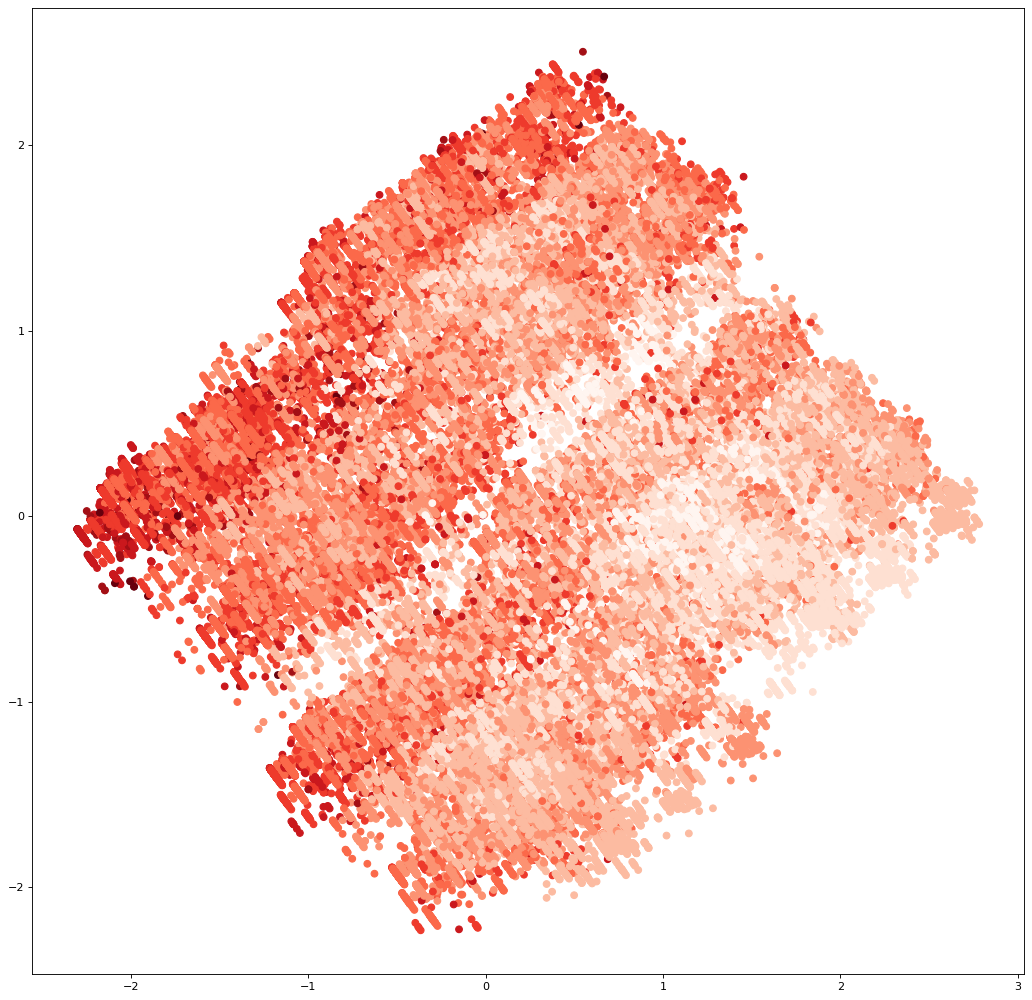

In [16]:
plt.figure(figsize=(16, 16), dpi=80)
plt.scatter(X[:,0],X[:,1],c = c, cmap= 'Reds')

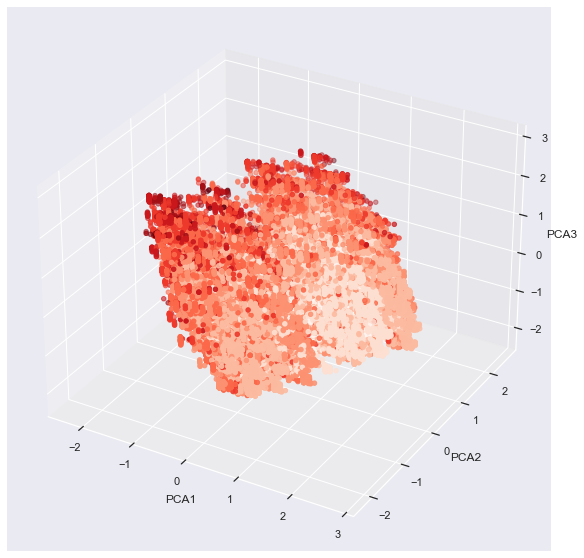

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection = '3d')

from sklearn.decomposition import PCA
X = PCA(n_components=3).fit_transform(sample_df)

x = X[:,0]
y = X[:,1]
z = X[:,2]

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

ax.scatter(x, y, z, c = c, cmap = 'Reds')

plt.show()

# How to navigate this space?

![milennium falcon](https://static.wikia.nocookie.net/starwars/images/5/52/Millennium_Falcon_Fathead_TROS.png)


## A few principles

- Useful images will likely be found nearby in the feature space, so indexing is important
- the database is likely to be updated frequently. New images are likely to be added, and new features may be introduced at any stage.
- we want to minimize computation, makinfg maximal use of dask and cython.
- we want deterministic results
- we have to strike a balance between recalculating when new data is available vs using memoized results.
- our aim is to organise and present images to a user.

## Assumption

- assume that we do not have control of the databse (it belongs to Stanford). We only have access.
- therefore we have to achieve some version control on our own system and generalize our functions to accommodate changes

## Useful Packages

### Boto 
- querying an S3 bucket. This allows us to provide cloud access to users and control and track access via credential management (IP protection and patient privacy)

### Django 
- to manage the feature database which corresponds to the images. 

### Luigi 
- to create data processing Pipelines with intermediate writes so we don't have to repeat calculations. Intermediate files to be salted based on data.

### Docker
- it may be possible to derive additional features for similar images that can be shared back with the user via deep learning modules. These can be built into the Luigi pipeline via a micro environment. The goal is to minimize the headache assosicated with deep learning libraries and CUDA.

## Advanced Python

### Optimization and memoization
- to deal with a large dataset

### Flexible parsing of user inputs.
- to accommdate various country's terminology of radiological findings

### Metaclasses and composition 
- within Luigi, to achieve multiple-image outputs.